# Section I: Preparation

# 1. Imports & Constants

In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from IPython.display import display, Markdown

In [2]:
# Constants
CLUSTERING_METRICS = ['ari', 'chs']

In [3]:
# constants
CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL = 'ari'
CLUSTERING_METRIC_TO_CONSIDER_INTERNAL = 'chs'

In [4]:
DATASETS_TO_SKIP = []  # put any datasets to skip here

In [5]:
MODEL_TO_DISPLAY_NAME_MAP = {
    'lstm-auto-encoder - encoder': 'LSTM-AE',
    'ts2vec - ts2vec': 'TS2Vec',
    'mcl - mcl': 'MCL',
    'timenet - timenet': 'TimeNet',
    'tsrc-mcl-lstmae - student-model-encoder': 'LSTM-AE w/ TSRC (MCL)',
    'tsrc-ts2vec-lstmae - student-model-encoder': 'LSTM-AE w/ TSRC (TS2Vec)',
    'tsrc-ts2vec-timenet - student-model-encoder': 'TimeNet w/ TSRC (TS2Vec)',
}

In [6]:
EXPERIMENTS_MAIN_OUTPUTS_DIR = Path('../experiments_outputs/')
CLUSTERING_MAIN_RESULTS_DIR = EXPERIMENTS_MAIN_OUTPUTS_DIR / 'clustering'

In [7]:
# Make a directory for storing the plots
PLOTS_OUTPUT_DIR = Path('./analysis_output')
PLOTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2. Functions

## 2.1. Plotting Functions

In [8]:
# This function is taken from Orange3 v.3.29.3 source code under GNU [GPL-3.0] license

def compute_CD(avranks, num_datasets, alpha="0.05", test="nemenyi"):
    """
    Computes the Critical Difference for Nemenyi test.
    """
    k = len(avranks)
    print(f"Number of datasets: {num_datasets}")
    print(f"Number of algorithms: {k}")
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * num_datasets)) ** 0.5
    return cd

In [9]:
# This function is taken from Orange3 v.3.29.3 source code under GNU [GPL-3.0] license

def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]

            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

## 2.2. Statistical Tests Functions

In [11]:
def perform_cd_analysis_multiple(means, algorithm_names, alpha="0.05"):
    """
    Perform Critical Difference Analysis with multiple runs.
    means is a 3D array: datasets x runs x algorithms
    """
    # Flatten runs and datasets into one dimension while keeping algorithms separate
    reshaped_means = means.reshape(-1, means.shape[2]).T
    ranks = np.array([stats.rankdata(-m) for m in reshaped_means.T])
    avg_ranks = np.mean(ranks, axis=0)
    stat, p_value = stats.friedmanchisquare(*reshaped_means)

    print(f"Statistics={stat}, p={p_value}")

    if p_value < 0.05:
        print("Significant differences found. Proceeding to CD analysis.")
        cd = compute_CD(avg_ranks, reshaped_means.shape[1], alpha)
        print(f"Critical difference: {cd}")
        # Print ranking of each algorithm
        sorted_indexes = np.argsort(avg_ranks)
        print("\nAlgorithm Name                 Rank")
        print("-------------------------------------")
        for i in sorted_indexes:
            print(f"{algorithm_names[i]:30s} {avg_ranks[i]:.2f}")
        graph_ranks(avranks=avg_ranks, names=algorithm_names, cd=cd, reverse=True, filename=None)
    else:
        print("No significant differences found.")


In [12]:
def do_cd_analysis_multiple(results_table, algorithms_names, algorithms_display_name):
    """
    Perform Critical Difference Analysis with multiple runs data.
    
    Arguments:
    results_table: DataFrame where each cell contains a list of performance data.
    algorithms_names: List of column names in results_table that correspond to different algorithms.
    algorithms_display_name: List of names for displaying the results.
    """
    # Gather all dataset names (index of the DataFrame)
    datasets = results_table.index.tolist()

    # Determine the number of runs (assuming uniform across all cells)
    number_of_runs = len(results_table.iloc[0, 0])

    # Preparing the 3D array: datasets x runs x algorithms
    data = np.empty((len(datasets), number_of_runs, len(algorithms_names)))

    for i, algorithm in enumerate(algorithms_names):
        for j, dataset in enumerate(datasets):
            data[j, :, i] = results_table.at[dataset, algorithm]

    # Pass the prepared data to the analysis function
    perform_cd_analysis_multiple(data, algorithms_display_name)


## 2.3. Utils Functions

In [14]:
def save_df_as_latex(df, filename, output_dir_path: Path = PLOTS_OUTPUT_DIR):
    """
    Save a DataFrame as a LaTeX table in a file.
    """
    df_copy = df.fillna('')  # Fill NaN values with empty strings

    full_file_path = output_dir_path / f'{filename}.tex'
    with open(full_file_path, 'w') as f:
        f.write(df_copy.style.to_latex(hrules=True, multicol_align='c', multirow_align='c'))

## 2.4. Data Processing Functions

In [17]:
def process_df_representations_results(df_results, datasets_to_skip):
    df_filtered = df_results[~df_results['dataset_name'].isin(datasets_to_skip)].copy()
    df_filtered['model_encoder_pair'] = df_filtered['model_name'] + " - " + df_filtered['encoder_name']
    return df_filtered

In [18]:
def compute_metrics_across_runs_representations(list_df_data,
                                                encoders_list,
                                                metrics,
                                                aggregate=True,
                                                values_format="mean"):
    encoder_metric_tables = {encoder: {} for encoder in encoders_list}
    metric_encoder_tables = {metric: {} for metric in metrics}

    # Table 1: One table per encoder
    for encoder in encoders_list:
        dataset_metric_values = {}

        for metric in metrics:
            for df_data in list_df_data:
                for dataset in df_data['dataset_name'].unique():
                    if dataset not in dataset_metric_values:
                        dataset_metric_values[dataset] = {m: [] for m in metrics}

            for df_data in list_df_data:
                df_filtered_data = df_data[df_data['model_encoder_pair'] == encoder]
                for dataset in df_filtered_data['dataset_name'].unique():
                    values = df_filtered_data[df_filtered_data['dataset_name'] == dataset][metric].tolist()
                    dataset_metric_values[dataset][metric].extend(values)

        if aggregate:
            for dataset, metrics_values in dataset_metric_values.items():
                for m, values in metrics_values.items():
                    mean = np.mean(values)
                    std = np.std(values)
                    dataset_metric_values[dataset][
                        m] = f"{mean:.2f} ± {std:.2f}" if values_format == 'mean_std' else mean

        result_table = pd.DataFrame.from_dict(dataset_metric_values, orient='index')
        encoder_metric_tables[encoder] = result_table

    # Table 2: One table per metric
    for metric in metrics:
        encoder_values = {}

        for encoder in encoders_list:
            for df_data in list_df_data:
                for dataset in df_data['dataset_name'].unique():
                    if dataset not in encoder_values:
                        encoder_values[dataset] = {e: [] for e in encoders_list}

            for df_data in list_df_data:
                df_filtered_data = df_data[df_data['model_encoder_pair'] == encoder]
                for dataset in df_filtered_data['dataset_name'].unique():
                    values = df_filtered_data[df_filtered_data['dataset_name'] == dataset][metric].tolist()
                    encoder_values[dataset][encoder].extend(values)

        if aggregate:
            for dataset, encoders_values in encoder_values.items():
                for e, values in encoders_values.items():
                    mean = np.mean(values)
                    std = np.std(values)
                    encoder_values[dataset][e] = f"{mean:.2f} ± {std:.2f}" if values_format == 'mean_std' else mean

        result_table = pd.DataFrame.from_dict(encoder_values, orient='index')
        metric_encoder_tables[metric] = result_table

    return encoder_metric_tables, metric_encoder_tables


In [19]:
def process_and_prepare_representations_data(data_folder_path: Path,
                                             datasets_to_skip: list,
                                             encoders_list: list,
                                             metrics: list,
                                             aggregate: bool = True,
                                             values_format: str = 'mean'):
    csv_files = [file for file in data_folder_path.iterdir() if file.suffix == '.csv']

    results_files_dataframes = [pd.read_csv(file) for file in csv_files]

    results_files_dataframes = [process_df_representations_results(df, datasets_to_skip) for df in
                                results_files_dataframes]

    encoder_metric_tables, metric_encoder_tables = compute_metrics_across_runs_representations(
        list_df_data=results_files_dataframes,
        encoders_list=encoders_list,
        metrics=metrics,
        aggregate=aggregate,
        values_format=values_format)

    return encoder_metric_tables, metric_encoder_tables

In [20]:
def analyze_representation_results(representations_results_folder: Path,
                                   metrics: list,
                                   encoders_list: list, ):
    encoder_metric_tables_display, metric_encoder_tables_display = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        values_format='mean_std')

    for metric in metrics:
        display(Markdown(f'### {metric.upper()} ###'))
        display(metric_encoder_tables_display[metric].sort_index())

    encoder_metric_tables, metric_encoder_tables = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        values_format='mean')

    return encoder_metric_tables, metric_encoder_tables, encoder_metric_tables_display, metric_encoder_tables_display

In [21]:
def analyze_representation_results_2(representations_results_folder: Path,
                                     metrics: list,
                                     encoders_list: list, ):
    encoder_metric_tables_mul, metric_encoder_tables_mul = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        aggregate=False,
        values_format='mean_std')

    return encoder_metric_tables_mul, metric_encoder_tables_mul

### 2.5. Summarising

In [23]:
def summarize_baselines_results(baselines_tables: dict,
                                clustering_metric_to_consider: str = CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL):
    df_summarized_baselines_results = pd.DataFrame()
    for baseline_name, baseline_table in baselines_tables.items():
        metric_table = baseline_table[clustering_metric_to_consider]
        df_summarized_baselines_results = pd.concat(
            [df_summarized_baselines_results, metric_table],
            axis=1)

    return df_summarized_baselines_results

# Section II: Analysis

# 3. Baselines

In [24]:
BASELINES_MAIN_DIR = CLUSTERING_MAIN_RESULTS_DIR / 'baselines'

## 3.1. LSTM Autoencoder (LSTM-AE)

In [25]:
lstm_ae_encoders_list = ['lstm-auto-encoder - encoder']
lstm_ae_main_dir = BASELINES_MAIN_DIR / 'ae'
lstm_ae_results_dir = lstm_ae_main_dir / 'compression_2'

In [26]:
lstm_ae_comp_2_encoder_metric_tables, lstm_ae_comp_2_metric_encoder_tables, lstm_ae_comp_2_encoder_metric_tables_display, lstm_ae_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=lstm_ae_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=lstm_ae_encoders_list)

### ARI ###

,lstm-auto-encoder - encoder
ACSF1,0.23 ± 0.02
Adiac,0.12 ± 0.03
ArrowHead,0.05 ± 0.01
BME,0.22 ± 0.07
Beef,0.04 ± 0.00
...,...
Wine,-0.01 ± 0.00
WordSynonyms,0.06 ± 0.01
Worms,0.04 ± 0.00
WormsTwoClass,-0.00 ± 0.00


### CHS ###

,lstm-auto-encoder - encoder
ACSF1,124.03 ± 27.44
Adiac,554.75 ± 330.38
ArrowHead,119.86 ± 32.01
BME,182.64 ± 78.64
Beef,1212.85 ± 418.01
...,...
Wine,55.94 ± 13.78
WordSynonyms,268.11 ± 61.29
Worms,394.48 ± 6.15
WormsTwoClass,268.58 ± 1.22


In [27]:
lstm_ae_comp_2_encoder_metric_tables_mul, lstm_ae_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=lstm_ae_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=lstm_ae_encoders_list)

## 3.2. TS2Vec

In [28]:
ts2vec_encoders_list = ['ts2vec - ts2vec']
ts2vec_main_dir = BASELINES_MAIN_DIR / 'ts2vec'
ts2vec_results_dir = ts2vec_main_dir / 'compression_2'

In [29]:
ts2vec_comp_2_encoder_metric_tables, ts2vec_comp_2_metric_encoder_tables, ts2vec_comp_2_encoder_metric_tables_display, ts2vec_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=ts2vec_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=ts2vec_encoders_list)

### ARI ###

,ts2vec - ts2vec
ACSF1,0.16 ± 0.01
Adiac,0.25 ± 0.02
ArrowHead,-0.01 ± 0.00
BME,-0.00 ± 0.00
Beef,0.08 ± 0.03
...,...
Wine,-0.01 ± 0.01
WordSynonyms,0.20 ± 0.03
Worms,0.06 ± 0.01
WormsTwoClass,0.04 ± 0.02


### CHS ###

,ts2vec - ts2vec
ACSF1,164.21 ± 34.50
Adiac,106.76 ± 19.63
ArrowHead,63.58 ± 9.14
BME,462.14 ± 80.76
Beef,44.79 ± 6.51
...,...
Wine,41.02 ± 2.10
WordSynonyms,25.24 ± 2.79
Worms,22.78 ± 3.42
WormsTwoClass,32.77 ± 4.34


In [30]:
ts2vec_comp_2_encoder_metric_tables_mul, ts2vec_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=ts2vec_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=ts2vec_encoders_list)

## 3.3. MCL

In [31]:
mcl_encoders_list = ['mcl - mcl']
mcl_main_dir = BASELINES_MAIN_DIR / 'mcl'
mcl_results_dir = mcl_main_dir / 'compression_2'

In [32]:
mcl_comp_2_encoder_metric_tables, mcl_comp_2_metric_encoder_tables, mcl_comp_2_encoder_metrics_tables_display, mcl_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=mcl_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=mcl_encoders_list)

### ARI ###

,mcl - mcl
ACSF1,0.26 ± 0.01
Adiac,0.31 ± 0.02
ArrowHead,0.09 ± 0.04
BME,0.25 ± 0.07
Beef,0.17 ± 0.06
...,...
Wine,0.04 ± 0.05
WordSynonyms,0.15 ± 0.01
Worms,-0.00 ± 0.01
WormsTwoClass,-0.00 ± 0.00


### CHS ###

,mcl - mcl
ACSF1,67.71 ± 12.97
Adiac,93.91 ± 10.38
ArrowHead,33.99 ± 6.30
BME,24.75 ± 3.34
Beef,25.39 ± 7.57
...,...
Wine,18.71 ± 3.79
WordSynonyms,39.91 ± 3.81
Worms,18.97 ± 1.52
WormsTwoClass,23.65 ± 1.19


In [33]:
mcl_comp_2_encoder_metric_tables_mul, mcl_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=mcl_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=mcl_encoders_list)

## 3.4. TimeNet

In [34]:
timenet_encoders_list = ['timenet - timenet']
timenet_main_dir = BASELINES_MAIN_DIR / 'timenet'
timenet_results_dir = timenet_main_dir / 'compression_2'

In [35]:
timenet_comp_2_encoder_metric_tables, timenet_comp_2_metric_encoder_tables, timenet_comp_2_encoder_metrics_tables_display, timenet_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=timenet_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=timenet_encoders_list)

### ARI ###

,timenet - timenet
ACSF1,0.22 ± 0.02
Adiac,0.14 ± 0.02
ArrowHead,0.05 ± 0.02
BME,0.37 ± 0.18
Beef,0.08 ± 0.04
...,...
Wine,0.01 ± 0.02
WordSynonyms,0.16 ± 0.01
Worms,0.06 ± 0.01
WormsTwoClass,0.00 ± 0.01


### CHS ###

,timenet - timenet
ACSF1,106.55 ± 23.43
Adiac,405.99 ± 136.36
ArrowHead,70.94 ± 24.64
BME,64.21 ± 8.69
Beef,180.20 ± 140.03
...,...
Wine,33.06 ± 5.19
WordSynonyms,96.31 ± 21.44
Worms,103.10 ± 68.16
WormsTwoClass,50.20 ± 6.23


In [36]:
timenet_comp_2_encoder_metric_tables_mul, timenet_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=timenet_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=timenet_encoders_list)

## 3.5. Baselines Summary

In [37]:
baselines_tables_display = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables_display,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables_display,
    'mcl': mcl_comp_2_metric_encoder_tables_display,
    'timenet': timenet_comp_2_metric_encoder_tables_display
}

In [38]:
baselines_tables = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables,
    'mcl': mcl_comp_2_metric_encoder_tables,
    'timenet': timenet_comp_2_metric_encoder_tables,
}

In [39]:
baselines_tables_mul = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables_mul,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables_mul,
    'mcl': mcl_comp_2_metric_encoder_tables_mul,
    'timenet': timenet_comp_2_metric_encoder_tables_mul,
}

### 3.5.1. Internal Clustering Metric

In [40]:
df_summarized_baselines_results_internal_display \
    = summarize_baselines_results(baselines_tables=baselines_tables_display,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_INTERNAL)


In [41]:
df_summarized_baselines_results_internal_display

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
ACSF1,124.03 ± 27.44,164.21 ± 34.50,67.71 ± 12.97,106.55 ± 23.43
Adiac,554.75 ± 330.38,106.76 ± 19.63,93.91 ± 10.38,405.99 ± 136.36
ArrowHead,119.86 ± 32.01,63.58 ± 9.14,33.99 ± 6.30,70.94 ± 24.64
BME,182.64 ± 78.64,462.14 ± 80.76,24.75 ± 3.34,64.21 ± 8.69
Beef,1212.85 ± 418.01,44.79 ± 6.51,25.39 ± 7.57,180.20 ± 140.03
...,...,...,...,...
Wine,55.94 ± 13.78,41.02 ± 2.10,18.71 ± 3.79,33.06 ± 5.19
WordSynonyms,268.11 ± 61.29,25.24 ± 2.79,39.91 ± 3.81,96.31 ± 21.44
Worms,394.48 ± 6.15,22.78 ± 3.42,18.97 ± 1.52,103.10 ± 68.16
WormsTwoClass,268.58 ± 1.22,32.77 ± 4.34,23.65 ± 1.19,50.20 ± 6.23


In [42]:
df_summarized_baselines_internal_results_mul \
    = summarize_baselines_results(baselines_tables=baselines_tables_mul,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_INTERNAL)

In [43]:
df_summarized_baselines_internal_results_mul

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
ACSF1,"[138.65267258898712, 110.83513997378267, 93.41...","[221.9748795261669, 184.81418210192672, 147.88...","[84.81739333499227, 75.2853359512572, 69.11723...","[116.64760116173512, 84.82407988246797, 146.02..."
Adiac,"[1186.5599046672742, 512.0756200834572, 462.96...","[86.08556007449528, 92.62213180623256, 109.647...","[92.16396073562072, 88.04952040130121, 113.098...","[464.5818769567569, 373.453392447212, 261.5301..."
ArrowHead,"[164.21964636710462, 92.69101653287048, 91.471...","[65.87029377462889, 52.86886725344559, 71.2928...","[37.41006324657927, 24.459856566331805, 42.430...","[61.33962066241251, 52.47194080064676, 59.4994..."
BME,"[179.49901092767968, 101.74206028261136, 224.2...","[589.5414748419389, 486.1135516263763, 356.211...","[25.404629146895783, 18.94817996206462, 23.575...","[65.82990758760964, 75.4267474848769, 70.51922..."
Beef,"[1122.5435807239903, 1851.664926890494, 558.64...","[57.137127457935, 38.29768048652891, 41.761614...","[23.023571370706968, 22.170471184899693, 34.83...","[52.70433071728422, 301.73929421783777, 388.89..."
...,...,...,...,...
Wine,"[67.18176943312797, 63.90429437770357, 29.0414...","[41.934172028615286, 40.58835094683691, 39.722...","[19.20342005559006, 16.242678975460578, 24.759...","[36.27105921512519, 39.00333979246757, 25.7259..."
WordSynonyms,"[236.12955482299083, 190.29561797369652, 375.1...","[30.233515439813676, 22.306706681730404, 24.22...","[47.014096121671976, 39.74904222416021, 37.353...","[65.43380292903228, 132.73135295902242, 93.142..."
Worms,"[392.5655991345074, 391.4308807674548, 391.288...","[20.93707216623141, 24.952432745404852, 18.638...","[20.135337483399265, 17.965097846263767, 20.32...","[59.1134306342484, 74.46766337260065, 69.53374..."
WormsTwoClass,"[267.7703361037256, 268.08223592747214, 267.28...","[33.09367874725126, 29.776774903893227, 29.522...","[22.62235997725007, 25.576723579509235, 24.141...","[43.79484792993338, 50.92367037779192, 55.7972..."


Statistics=1146.3321428571435, p=3.2293240142992232e-248
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 4
Critical difference: 0.19820512187990647

Algorithm Name                 Rank
-------------------------------------
LSTM-AE                        1.38
TimeNet                        1.93
TS2Vec                         2.89
MCL                            3.80


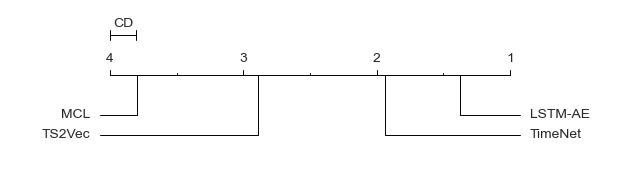

In [44]:
baselines_display_names = ['LSTM-AE', 'TS2Vec', 'MCL', 'TimeNet']
do_cd_analysis_multiple(df_summarized_baselines_internal_results_mul,
                        df_summarized_baselines_internal_results_mul.columns,
                        baselines_display_names)

plt.savefig(PLOTS_OUTPUT_DIR / 'baselines_cd_internal.eps', format='eps', bbox_inches='tight', dpi=300)

### 3.5.2. External Clustering Metric

In [46]:
df_summarized_baselines_results_external_display \
    = summarize_baselines_results(baselines_tables=baselines_tables_display,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL)


In [47]:
df_summarized_baselines_results_external_display

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
ACSF1,0.23 ± 0.02,0.16 ± 0.01,0.26 ± 0.01,0.22 ± 0.02
Adiac,0.12 ± 0.03,0.25 ± 0.02,0.31 ± 0.02,0.14 ± 0.02
ArrowHead,0.05 ± 0.01,-0.01 ± 0.00,0.09 ± 0.04,0.05 ± 0.02
BME,0.22 ± 0.07,-0.00 ± 0.00,0.25 ± 0.07,0.37 ± 0.18
Beef,0.04 ± 0.00,0.08 ± 0.03,0.17 ± 0.06,0.08 ± 0.04
...,...,...,...,...
Wine,-0.01 ± 0.00,-0.01 ± 0.01,0.04 ± 0.05,0.01 ± 0.02
WordSynonyms,0.06 ± 0.01,0.20 ± 0.03,0.15 ± 0.01,0.16 ± 0.01
Worms,0.04 ± 0.00,0.06 ± 0.01,-0.00 ± 0.01,0.06 ± 0.01
WormsTwoClass,-0.00 ± 0.00,0.04 ± 0.02,-0.00 ± 0.00,0.00 ± 0.01


In [48]:
df_summarized_baselines_external_results_mul \
    = summarize_baselines_results(baselines_tables=baselines_tables_mul,
                                  clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL)

In [49]:
df_summarized_baselines_external_results_mul

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
ACSF1,"[0.2687634024303074, 0.2249538041295091, 0.209...","[0.1460556601799539, 0.1633524323109763, 0.140...","[0.2431275720164609, 0.2598063351386837, 0.261...","[0.2390230128476634, 0.1824705279343926, 0.242..."
Adiac,"[0.1004536734002934, 0.0926709114363123, 0.106...","[0.255732005759293, 0.2621799395403948, 0.2193...","[0.3494742508023928, 0.3183287473297975, 0.313...","[0.1246157676176382, 0.1765779371971556, 0.129..."
ArrowHead,"[0.0523533348534085, 0.0306864472980531, 0.069...","[-0.0019887374668678, -0.007615017411341, -0.0...","[0.1524695012222832, 0.0891879000835918, 0.028...","[0.0185077769077625, 0.0332085597924477, 0.078..."
BME,"[0.1531043732230837, 0.2628428661926386, 0.153...","[-0.0005853140209722, 5.227778673276902e-05, 5...","[0.2970952135085001, 0.2056986827800672, 0.334...","[0.40703819661866, 0.6797352726540677, 0.35807..."
Beef,"[0.0442031795269484, 0.0442031795269484, 0.044...","[0.1005207154177043, 0.0543478260869565, 0.122...","[0.215137614678899, 0.1017161992465466, 0.2077...","[0.1561391057487579, 0.0442031795269484, 0.089..."
...,...,...,...,...
Wine,"[-0.0127427522118969, -0.0139928353991826, -0....","[-0.0130980795668271, 0.0023130222647372, -0.0...","[0.0079068205470934, -0.0166882518681444, 0.00...","[0.0452452047168379, -0.0068025604081536, 0.01..."
WordSynonyms,"[0.0578417090147695, 0.0671517989014716, 0.048...","[0.1631444466814253, 0.2366777707657013, 0.187...","[0.1418407981382156, 0.1508697482807301, 0.135...","[0.1563730414992939, 0.1687634732412142, 0.161..."
Worms,"[0.0519121322794803, 0.0437424068595912, 0.038...","[0.0483003655141829, 0.0520481298102271, 0.083...","[-0.003245655418223, 0.0053743946963193, -0.00...","[0.0683734241411386, 0.0622753496766431, 0.052..."
WormsTwoClass,"[-0.0048039208782541, -0.0028387099197115, -0....","[0.042178623136506, 0.0426313686890855, 0.0746...","[-0.0057829625694558, -0.0071164394701918, 0.0...","[0.0136340857309657, 0.0023409835511396, -0.00..."


In [50]:
df_summarized_baselines_external_results_mul = summarize_baselines_results(baselines_tables=baselines_tables_mul,
                                                                           clustering_metric_to_consider=CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL)

Statistics=91.40281377267817, p=1.0945278766303095e-19
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 4
Critical difference: 0.19820512187990647

Algorithm Name                 Rank
-------------------------------------
TS2Vec                         2.20
TimeNet                        2.33
MCL                            2.61
LSTM-AE                        2.86


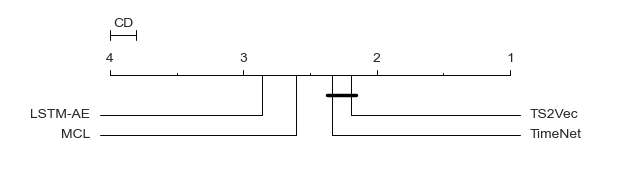

In [51]:
baselines_display_names = ['LSTM-AE', 'TS2Vec', 'MCL', 'TimeNet']
do_cd_analysis_multiple(df_summarized_baselines_external_results_mul,
                        df_summarized_baselines_external_results_mul.columns,
                        baselines_display_names)

plt.savefig(PLOTS_OUTPUT_DIR / 'baselines_cd.eps', format='eps', bbox_inches='tight', dpi=300)

# 4. TSRC

In [55]:
TSRC_MODEL_MAIN_DIR = CLUSTERING_MAIN_RESULTS_DIR / 'representations'

## 4.1. External Clustering Metric

### 4.1.1 Experiment 1

In [56]:
experiment_1_main_dir = TSRC_MODEL_MAIN_DIR / 'ts2vec_to_timenet_88c1e7d54bda54398837d6eff0022678'

In [57]:
experiment_1_results_dir = experiment_1_main_dir / 'compression_2'

In [58]:
experiment_1_encoders_list = ['tsrc-ts2vec-timenet - student-model-encoder']

In [59]:
experiment_1_encoder_metric_tables, experiment_1_metric_encoder_tables, experiment_1_encoder_metric_tables_display, experiment_1_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_1_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=experiment_1_encoders_list)

### ARI ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,0.19 ± 0.02
Adiac,0.22 ± 0.03
ArrowHead,0.03 ± 0.03
BME,0.30 ± 0.11
Beef,0.12 ± 0.05
...,...
Wine,0.00 ± 0.02
WordSynonyms,0.18 ± 0.02
Worms,0.05 ± 0.01
WormsTwoClass,0.00 ± 0.01


### CHS ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,87.32 ± 14.40
Adiac,187.50 ± 17.43
ArrowHead,67.50 ± 13.25
BME,190.34 ± 66.11
Beef,37.08 ± 16.03
...,...
Wine,48.29 ± 11.50
WordSynonyms,66.00 ± 5.62
Worms,57.47 ± 3.43
WormsTwoClass,47.24 ± 4.81


In [60]:
experiment_1_encoder_metric_tables_mul, experiment_1_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_1_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=experiment_1_encoders_list)

In [61]:
experiment_1_baselines_columns = ['ts2vec - ts2vec', 'timenet - timenet']
experiment_1_baseline_results_mul = df_summarized_baselines_external_results_mul[experiment_1_baselines_columns]

In [62]:
experiment_1_results_mul = pd.concat([experiment_1_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
                                      experiment_1_baseline_results_mul], axis=1)

In [63]:
experiment_1_results_mul

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
ACSF1,"[0.1751800916830386, 0.1890776126444916, 0.164...","[0.1460556601799539, 0.1633524323109763, 0.140...","[0.2390230128476634, 0.1824705279343926, 0.242..."
Adiac,"[0.2033599667115128, 0.2289319214991436, 0.268...","[0.255732005759293, 0.2621799395403948, 0.2193...","[0.1246157676176382, 0.1765779371971556, 0.129..."
ArrowHead,"[0.0385719736947621, -0.0028817525223046, 0.06...","[-0.0019887374668678, -0.007615017411341, -0.0...","[0.0185077769077625, 0.0332085597924477, 0.078..."
BME,"[0.1547334114172225, 0.3914258857644883, 0.418...","[-0.0005853140209722, 5.227778673276902e-05, 5...","[0.40703819661866, 0.6797352726540677, 0.35807..."
Beef,"[0.0554738390418155, 0.1411383618695048, 0.198...","[0.1005207154177043, 0.0543478260869565, 0.122...","[0.1561391057487579, 0.0442031795269484, 0.089..."
...,...,...,...
Wine,"[0.0040604879658993, 0.0059756435793348, -0.01...","[-0.0130980795668271, 0.0023130222647372, -0.0...","[0.0452452047168379, -0.0068025604081536, 0.01..."
WordSynonyms,"[0.1448956754051437, 0.2063182473651053, 0.211...","[0.1631444466814253, 0.2366777707657013, 0.187...","[0.1563730414992939, 0.1687634732412142, 0.161..."
Worms,"[0.0658513193307987, 0.0365304444092738, 0.043...","[0.0483003655141829, 0.0520481298102271, 0.083...","[0.0683734241411386, 0.0622753496766431, 0.052..."
WormsTwoClass,"[-0.0009069351182092, -0.0013024430674507, -0....","[0.042178623136506, 0.0426313686890855, 0.0746...","[0.0136340857309657, 0.0023409835511396, -0.00..."


In [64]:
experiment_1_results_mul

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
ACSF1,"[0.1751800916830386, 0.1890776126444916, 0.164...","[0.1460556601799539, 0.1633524323109763, 0.140...","[0.2390230128476634, 0.1824705279343926, 0.242..."
Adiac,"[0.2033599667115128, 0.2289319214991436, 0.268...","[0.255732005759293, 0.2621799395403948, 0.2193...","[0.1246157676176382, 0.1765779371971556, 0.129..."
ArrowHead,"[0.0385719736947621, -0.0028817525223046, 0.06...","[-0.0019887374668678, -0.007615017411341, -0.0...","[0.0185077769077625, 0.0332085597924477, 0.078..."
BME,"[0.1547334114172225, 0.3914258857644883, 0.418...","[-0.0005853140209722, 5.227778673276902e-05, 5...","[0.40703819661866, 0.6797352726540677, 0.35807..."
Beef,"[0.0554738390418155, 0.1411383618695048, 0.198...","[0.1005207154177043, 0.0543478260869565, 0.122...","[0.1561391057487579, 0.0442031795269484, 0.089..."
...,...,...,...
Wine,"[0.0040604879658993, 0.0059756435793348, -0.01...","[-0.0130980795668271, 0.0023130222647372, -0.0...","[0.0452452047168379, -0.0068025604081536, 0.01..."
WordSynonyms,"[0.1448956754051437, 0.2063182473651053, 0.211...","[0.1631444466814253, 0.2366777707657013, 0.187...","[0.1563730414992939, 0.1687634732412142, 0.161..."
Worms,"[0.0658513193307987, 0.0365304444092738, 0.043...","[0.0483003655141829, 0.0520481298102271, 0.083...","[0.0683734241411386, 0.0622753496766431, 0.052..."
WormsTwoClass,"[-0.0009069351182092, -0.0013024430674507, -0....","[0.042178623136506, 0.0426313686890855, 0.0746...","[0.0136340857309657, 0.0023409835511396, -0.00..."


In [65]:
experiment_1_baselines_results_display = df_summarized_baselines_results_external_display[
    experiment_1_baselines_columns]
experiment_1_results_display = pd.concat(
    [experiment_1_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
     experiment_1_baselines_results_display], axis=1)

In [66]:
experiment_1_results_display

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
ACSF1,0.19 ± 0.02,0.16 ± 0.01,0.22 ± 0.02
Adiac,0.22 ± 0.03,0.25 ± 0.02,0.14 ± 0.02
ArrowHead,0.03 ± 0.03,-0.01 ± 0.00,0.05 ± 0.02
BME,0.30 ± 0.11,-0.00 ± 0.00,0.37 ± 0.18
Beef,0.12 ± 0.05,0.08 ± 0.03,0.08 ± 0.04
...,...,...,...
Wine,0.00 ± 0.02,-0.01 ± 0.01,0.01 ± 0.02
WordSynonyms,0.18 ± 0.02,0.20 ± 0.03,0.16 ± 0.01
Worms,0.05 ± 0.01,0.06 ± 0.01,0.06 ± 0.01
WormsTwoClass,0.00 ± 0.01,0.04 ± 0.02,0.00 ± 0.01


### 4.1.2 Experiment 2

In [67]:
experiment_2_main_dir = TSRC_MODEL_MAIN_DIR / 'ts2vec_to_lstmae_aecc4ffa8c36aa6d9bccaf9d83dac024'

In [68]:
experiment_2_results_dir = experiment_2_main_dir / 'compression_2'

In [69]:
experiment_2_encoders_list = ['tsrc-ts2vec-lstmae - student-model-encoder']

In [70]:
experiment_2_encoder_metric_tables, experiment_2_metric_encoder_tables, experiment_2_encoder_metric_tables_display, experiment_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_2_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=experiment_2_encoders_list)

### ARI ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,0.23 ± 0.01
Adiac,0.18 ± 0.03
ArrowHead,0.09 ± 0.03
BME,0.21 ± 0.10
Beef,0.04 ± 0.00
...,...
Wine,0.00 ± 0.01
WordSynonyms,0.12 ± 0.01
Worms,0.05 ± 0.01
WormsTwoClass,-0.00 ± 0.00


### CHS ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,131.70 ± 10.39
Adiac,353.35 ± 104.14
ArrowHead,89.98 ± 10.55
BME,378.58 ± 91.95
Beef,962.64 ± 83.37
...,...
Wine,111.66 ± 34.72
WordSynonyms,101.97 ± 15.82
Worms,149.01 ± 118.86
WormsTwoClass,191.95 ± 86.71


In [71]:
experiment_2_encoder_metric_tables_mul, experiment_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_2_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=experiment_2_encoders_list)

In [72]:
experiment_2_baselines_columns = ['ts2vec - ts2vec', 'lstm-auto-encoder - encoder']
experiment_2_baselines_results_mul = df_summarized_baselines_external_results_mul[experiment_2_baselines_columns]

In [73]:
experiment_2_results_mul = pd.concat([experiment_2_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
                                      experiment_2_baselines_results_mul], axis=1)

In [74]:
experiment_2_baselines_results_display = df_summarized_baselines_results_external_display[
    experiment_2_baselines_columns]
experiment_2_results_display = pd.concat(
    [experiment_2_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
     experiment_2_baselines_results_display], axis=1)

In [75]:
experiment_2_results_display

,tsrc-ts2vec-lstmae - student-model-encoder,ts2vec - ts2vec,lstm-auto-encoder - encoder
ACSF1,0.23 ± 0.01,0.16 ± 0.01,0.23 ± 0.02
Adiac,0.18 ± 0.03,0.25 ± 0.02,0.12 ± 0.03
ArrowHead,0.09 ± 0.03,-0.01 ± 0.00,0.05 ± 0.01
BME,0.21 ± 0.10,-0.00 ± 0.00,0.22 ± 0.07
Beef,0.04 ± 0.00,0.08 ± 0.03,0.04 ± 0.00
...,...,...,...
Wine,0.00 ± 0.01,-0.01 ± 0.01,-0.01 ± 0.00
WordSynonyms,0.12 ± 0.01,0.20 ± 0.03,0.06 ± 0.01
Worms,0.05 ± 0.01,0.06 ± 0.01,0.04 ± 0.00
WormsTwoClass,-0.00 ± 0.00,0.04 ± 0.02,-0.00 ± 0.00


### 4.1.3 Experiment 3

In [76]:
experiment_3_main_dir = TSRC_MODEL_MAIN_DIR / 'mcl_to_lstmae_841548f56ad1cc5fd09a9f2e2086e6df'

In [77]:
experiment_3_results_dir = experiment_3_main_dir / 'compression_2'

In [78]:
experiment_3_encoders_list = ['tsrc-mcl-lstmae - student-model-encoder']

In [79]:
experiment_3_encoder_metric_tables, experiment_3_metric_encoder_tables, experiment_3_encoder_metric_tables_display, experiment_3_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_3_results_dir,
                                   metrics=CLUSTERING_METRICS,
                                   encoders_list=experiment_3_encoders_list)

### ARI ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,0.21 ± 0.04
Adiac,0.23 ± 0.04
ArrowHead,0.11 ± 0.03
BME,0.33 ± 0.13
Beef,0.11 ± 0.02
...,...
Wine,0.00 ± 0.01
WordSynonyms,0.09 ± 0.02
Worms,0.03 ± 0.02
WormsTwoClass,-0.01 ± 0.00


### CHS ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,418.45 ± 415.06
Adiac,109.51 ± 29.18
ArrowHead,56.73 ± 20.18
BME,90.85 ± 30.39
Beef,1517.10 ± 851.21
...,...
Wine,133.25 ± 192.82
WordSynonyms,162.49 ± 62.18
Worms,1252.17 ± 227.58
WormsTwoClass,404.59 ± 353.53


In [80]:
experiment_3_encoder_metric_tables_mul, experiment_3_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_3_results_dir,
    metrics=CLUSTERING_METRICS,
    encoders_list=experiment_3_encoders_list)

In [81]:
experiment_3_baselines_columns = ['mcl - mcl', 'lstm-auto-encoder - encoder']

In [82]:
experiment_3_baselines_results_mul = df_summarized_baselines_external_results_mul[experiment_3_baselines_columns]

In [83]:
experiment_3_results_mul = pd.concat([experiment_3_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
                                      experiment_3_baselines_results_mul], axis=1)

In [84]:
experiment_3_baselines_results_display = df_summarized_baselines_results_external_display[
    experiment_3_baselines_columns]
experiment_3_results_display = pd.concat(
    [experiment_3_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_EXTERNAL],
     experiment_3_baselines_results_display], axis=1)

## 4.1.4. All Experiments

In [85]:
all_experiments_results_mul = pd.concat([experiment_1_results_mul, experiment_2_results_mul, experiment_3_results_mul,
                                         df_summarized_baselines_external_results_mul], axis=1)
all_experiments_results_mul = all_experiments_results_mul.loc[:, ~all_experiments_results_mul.columns.duplicated()]

In [86]:
all_experiment_results_display = pd.concat(
    [experiment_1_results_display, experiment_2_results_display, experiment_3_results_display], axis=1)
all_experiment_results_display = all_experiment_results_display.loc[:,
                                 ~all_experiment_results_display.columns.duplicated()]
# rename the columns to be more descriptive (use the mapping)
all_experiment_results_display.columns = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in
                                          all_experiment_results_display.columns]
# order the columns and put the baselines first
all_experiment_results_display = all_experiment_results_display[
    baselines_display_names + all_experiment_results_display.columns.difference(baselines_display_names).tolist()]

In [87]:
all_experiment_results_display

,LSTM-AE,TS2Vec,MCL,TimeNet,LSTM-AE w/ TSRC (MCL),LSTM-AE w/ TSRC (TS2Vec),TimeNet w/ TSRC (TS2Vec)
ACSF1,0.23 ± 0.02,0.16 ± 0.01,0.26 ± 0.01,0.22 ± 0.02,0.21 ± 0.04,0.23 ± 0.01,0.19 ± 0.02
Adiac,0.12 ± 0.03,0.25 ± 0.02,0.31 ± 0.02,0.14 ± 0.02,0.23 ± 0.04,0.18 ± 0.03,0.22 ± 0.03
ArrowHead,0.05 ± 0.01,-0.01 ± 0.00,0.09 ± 0.04,0.05 ± 0.02,0.11 ± 0.03,0.09 ± 0.03,0.03 ± 0.03
BME,0.22 ± 0.07,-0.00 ± 0.00,0.25 ± 0.07,0.37 ± 0.18,0.33 ± 0.13,0.21 ± 0.10,0.30 ± 0.11
Beef,0.04 ± 0.00,0.08 ± 0.03,0.17 ± 0.06,0.08 ± 0.04,0.11 ± 0.02,0.04 ± 0.00,0.12 ± 0.05
...,...,...,...,...,...,...,...
Wine,-0.01 ± 0.00,-0.01 ± 0.01,0.04 ± 0.05,0.01 ± 0.02,0.00 ± 0.01,0.00 ± 0.01,0.00 ± 0.02
WordSynonyms,0.06 ± 0.01,0.20 ± 0.03,0.15 ± 0.01,0.16 ± 0.01,0.09 ± 0.02,0.12 ± 0.01,0.18 ± 0.02
Worms,0.04 ± 0.00,0.06 ± 0.01,-0.00 ± 0.01,0.06 ± 0.01,0.03 ± 0.02,0.05 ± 0.01,0.05 ± 0.01
WormsTwoClass,-0.00 ± 0.00,0.04 ± 0.02,-0.00 ± 0.00,0.00 ± 0.01,-0.01 ± 0.00,-0.00 ± 0.00,0.00 ± 0.01


In [88]:
# save as latex
save_df_as_latex(all_experiment_results_display, 'all_experiments_results')

Statistics=156.61873754152845, p=3.0786569050092414e-31
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 7
Critical difference: 0.38062647530967497

Algorithm Name                 Rank
-------------------------------------
TimeNet w/ TSRC (TS2Vec)       3.48
TS2Vec                         3.53
TimeNet                        3.77
LSTM-AE w/ TSRC (TS2Vec)       3.93
MCL                            4.16
LSTM-AE w/ TSRC (MCL)          4.40
LSTM-AE                        4.73


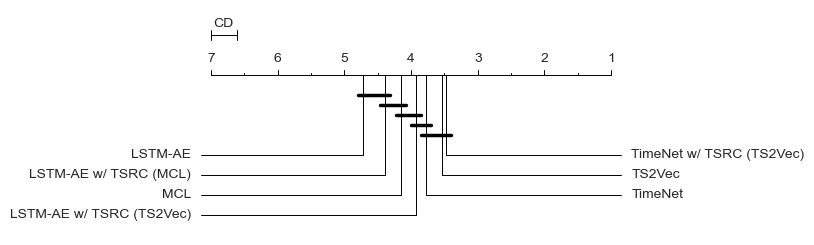

In [89]:
all_experiments_display_names = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in all_experiments_results_mul.columns]

do_cd_analysis_multiple(all_experiments_results_mul, all_experiments_results_mul.columns, all_experiments_display_names)

# save the figure as eps
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd.eps', format='eps', bbox_inches='tight', dpi=300)

# save the figure as png
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd.png', format='png', bbox_inches='tight', dpi=300)

In [90]:
# Calculating improvements:

ranks_original = {
    "TimeNet_w_TSRC_TS2Vec": 3.48,
    "TS2Vec": 3.53,
    "TimeNet": 3.77,
    "LSTM_AE_w_TSRC_TS2Vec": 3.93,
    "MCL": 4.16,
    "LSTM_AE_w_TSRC_MCL": 4.40,
    "LSTM_AE": 4.73
}
improvements = {
    "TimeNet_w_TSRC_TS2Vec": ((ranks_original["TimeNet"] - ranks_original["TimeNet_w_TSRC_TS2Vec"]) / ranks_original[
        "TimeNet"]) * 100,
    "LSTM_AE_w_TSRC_TS2Vec": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_TS2Vec"]) / ranks_original[
        "LSTM_AE"]) * 100,
    "LSTM_AE_w_TSRC_MCL": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_MCL"]) / ranks_original[
        "LSTM_AE"]) * 100,
}

# Calculate the mean of the improvements:
mean_improvement = sum(improvements.values()) / len(improvements)
improvements, mean_improvement

({'TimeNet_w_TSRC_TS2Vec': 7.6923076923076925,
  'LSTM_AE_w_TSRC_TS2Vec': 16.913319238900637,
  'LSTM_AE_w_TSRC_MCL': 6.976744186046513},
 10.527457039084949)

## 4.2. Internal Clustering Metric

### 4.2.1 Experiment 1

In [91]:
experiment_1_results_mul_internal = pd.concat(
    [experiment_1_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_1_baseline_results_mul], axis=1)

In [92]:
experiment_1_baselines_results_display_internal = df_summarized_baselines_results_internal_display[
    experiment_1_baselines_columns]
experiment_1_results_display_internal = pd.concat(
    [experiment_1_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_1_baselines_results_display_internal], axis=1)

In [93]:
experiment_1_results_display_internal

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
ACSF1,87.32 ± 14.40,164.21 ± 34.50,106.55 ± 23.43
Adiac,187.50 ± 17.43,106.76 ± 19.63,405.99 ± 136.36
ArrowHead,67.50 ± 13.25,63.58 ± 9.14,70.94 ± 24.64
BME,190.34 ± 66.11,462.14 ± 80.76,64.21 ± 8.69
Beef,37.08 ± 16.03,44.79 ± 6.51,180.20 ± 140.03
...,...,...,...
Wine,48.29 ± 11.50,41.02 ± 2.10,33.06 ± 5.19
WordSynonyms,66.00 ± 5.62,25.24 ± 2.79,96.31 ± 21.44
Worms,57.47 ± 3.43,22.78 ± 3.42,103.10 ± 68.16
WormsTwoClass,47.24 ± 4.81,32.77 ± 4.34,50.20 ± 6.23


### 4.2.2 Experiment 2

In [94]:
experiment_2_results_mul_internal = pd.concat(
    [experiment_2_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_2_baselines_results_mul], axis=1)

In [95]:
experiment_2_baselines_results_display_internal = df_summarized_baselines_results_internal_display[
    experiment_2_baselines_columns]
experiment_2_results_display_internal = pd.concat(
    [experiment_2_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_2_baselines_results_display_internal], axis=1)

In [96]:
experiment_2_results_display_internal

,tsrc-ts2vec-lstmae - student-model-encoder,ts2vec - ts2vec,lstm-auto-encoder - encoder
ACSF1,131.70 ± 10.39,164.21 ± 34.50,124.03 ± 27.44
Adiac,353.35 ± 104.14,106.76 ± 19.63,554.75 ± 330.38
ArrowHead,89.98 ± 10.55,63.58 ± 9.14,119.86 ± 32.01
BME,378.58 ± 91.95,462.14 ± 80.76,182.64 ± 78.64
Beef,962.64 ± 83.37,44.79 ± 6.51,1212.85 ± 418.01
...,...,...,...
Wine,111.66 ± 34.72,41.02 ± 2.10,55.94 ± 13.78
WordSynonyms,101.97 ± 15.82,25.24 ± 2.79,268.11 ± 61.29
Worms,149.01 ± 118.86,22.78 ± 3.42,394.48 ± 6.15
WormsTwoClass,191.95 ± 86.71,32.77 ± 4.34,268.58 ± 1.22


### 4.2.3 Experiment 3

In [97]:
experiment_3_results_mul_internal = pd.concat(
    [experiment_3_metric_encoder_tables_mul[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_3_baselines_results_mul], axis=1)

In [98]:
experiment_3_baselines_results_display_internal = df_summarized_baselines_results_internal_display[
    experiment_3_baselines_columns]
experiment_3_results_display_internal = pd.concat(
    [experiment_3_metric_encoder_tables_display[CLUSTERING_METRIC_TO_CONSIDER_INTERNAL],
     experiment_3_baselines_results_display_internal], axis=1)

## 4.2.4. All Experiments

In [99]:
all_experiments_results_mul_internal = pd.concat(
    [experiment_1_results_mul_internal, experiment_2_results_mul_internal, experiment_3_results_mul_internal,
     df_summarized_baselines_internal_results_mul], axis=1)
all_experiments_results_mul_internal = all_experiments_results_mul_internal.loc[:,
                                       ~all_experiments_results_mul_internal.columns.duplicated()]

In [100]:
all_experiment_results_display_internal = pd.concat(
    [experiment_1_results_display_internal, experiment_2_results_display_internal,
     experiment_3_results_display_internal], axis=1)
all_experiment_results_display_internal = all_experiment_results_display_internal.loc[:,
                                          ~all_experiment_results_display_internal.columns.duplicated()]
# rename the columns to be more descriptive (use the mapping)
all_experiment_results_display_internal.columns = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in
                                                   all_experiment_results_display_internal.columns]
# order the columns and put the baselines first
all_experiment_results_display_internal = all_experiment_results_display_internal[
    baselines_display_names + all_experiment_results_display_internal.columns.difference(
        baselines_display_names).tolist()]

In [101]:
all_experiment_results_display_internal

,LSTM-AE,TS2Vec,MCL,TimeNet,LSTM-AE w/ TSRC (MCL),LSTM-AE w/ TSRC (TS2Vec),TimeNet w/ TSRC (TS2Vec)
ACSF1,124.03 ± 27.44,164.21 ± 34.50,67.71 ± 12.97,106.55 ± 23.43,418.45 ± 415.06,131.70 ± 10.39,87.32 ± 14.40
Adiac,554.75 ± 330.38,106.76 ± 19.63,93.91 ± 10.38,405.99 ± 136.36,109.51 ± 29.18,353.35 ± 104.14,187.50 ± 17.43
ArrowHead,119.86 ± 32.01,63.58 ± 9.14,33.99 ± 6.30,70.94 ± 24.64,56.73 ± 20.18,89.98 ± 10.55,67.50 ± 13.25
BME,182.64 ± 78.64,462.14 ± 80.76,24.75 ± 3.34,64.21 ± 8.69,90.85 ± 30.39,378.58 ± 91.95,190.34 ± 66.11
Beef,1212.85 ± 418.01,44.79 ± 6.51,25.39 ± 7.57,180.20 ± 140.03,1517.10 ± 851.21,962.64 ± 83.37,37.08 ± 16.03
...,...,...,...,...,...,...,...
Wine,55.94 ± 13.78,41.02 ± 2.10,18.71 ± 3.79,33.06 ± 5.19,133.25 ± 192.82,111.66 ± 34.72,48.29 ± 11.50
WordSynonyms,268.11 ± 61.29,25.24 ± 2.79,39.91 ± 3.81,96.31 ± 21.44,162.49 ± 62.18,101.97 ± 15.82,66.00 ± 5.62
Worms,394.48 ± 6.15,22.78 ± 3.42,18.97 ± 1.52,103.10 ± 68.16,1252.17 ± 227.58,149.01 ± 118.86,57.47 ± 3.43
WormsTwoClass,268.58 ± 1.22,32.77 ± 4.34,23.65 ± 1.19,50.20 ± 6.23,404.59 ± 353.53,191.95 ± 86.71,47.24 ± 4.81


In [102]:
# save as latex
save_df_as_latex(all_experiment_results_display_internal, 'all_experiments_results_internal')

Statistics=2594.6520762467094, p=0.0
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 7
Critical difference: 0.38062647530967497

Algorithm Name                 Rank
-------------------------------------
LSTM-AE w/ TSRC (TS2Vec)       1.64
LSTM-AE w/ TSRC (MCL)          2.06
TimeNet w/ TSRC (TS2Vec)       2.30
TS2Vec                         5.20
TimeNet                        5.33
MCL                            5.61
LSTM-AE                        5.86


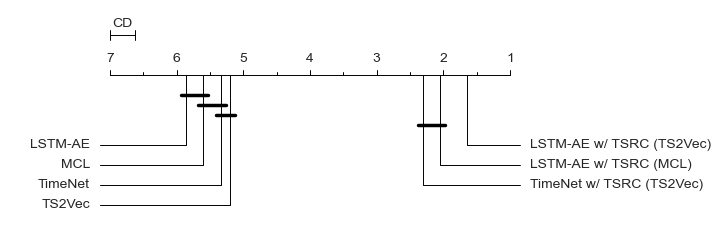

In [103]:
all_experiments_display_names = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in all_experiments_results_mul_internal.columns]

do_cd_analysis_multiple(all_experiments_results_mul_internal, all_experiments_results_mul_internal.columns,
                        all_experiments_display_names)

# save the figure as eps
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd_internal.eps', format='eps', bbox_inches='tight', dpi=300)

# save the figure as png
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd_internal.png', format='png', bbox_inches='tight', dpi=300)

In [104]:
# Calculating improvements:

ranks_original = {
    "LSTM_AE_w_TSRC_TS2Vec": 1.64,
    "LSTM_AE_w_TSRC_MCL": 2.06,
    "TimeNet_w_TSRC_TS2Vec": 2.30,
    "TS2Vec": 5.20,
    "TimeNet": 5.33,
    "MCL": 5.61,
    "LSTM_AE": 5.86
}
improvements = {
    "TimeNet_w_TSRC_TS2Vec": ((ranks_original["TimeNet"] - ranks_original["TimeNet_w_TSRC_TS2Vec"]) / ranks_original[
        "TimeNet"]) * 100,
    "LSTM_AE_w_TSRC_TS2Vec": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_TS2Vec"]) / ranks_original[
        "LSTM_AE"]) * 100,
    "LSTM_AE_w_TSRC_MCL": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_MCL"]) / ranks_original[
        "LSTM_AE"]) * 100,
}

# Calculate the mean of the improvements:
mean_improvement = sum(improvements.values()) / len(improvements)
improvements, mean_improvement

({'TimeNet_w_TSRC_TS2Vec': 56.84803001876173,
  'LSTM_AE_w_TSRC_TS2Vec': 72.01365187713311,
  'LSTM_AE_w_TSRC_MCL': 64.84641638225256},
 64.5693660927158)